# Sample

In [1]:
import torch
import pickle
import numpy as np
from modules.wrapper import set_model
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from dataset import VQACaptionDataset
from util.utils import get_vocab_list
from tools.visualize import *

In [13]:
load_path = 'base+gat+cap-pred'
pretrain_model_name = 'epoch_3.pt'
finetune_model_name = 'fine-tune/epoch_21.pt'
device = 'cpu'
sample = 1679

In [3]:
class Argument():
    def __init__(self, load_path):
        with open(os.path.join('checkpoint', load_path, 'param.pkl'), 'rb') as f: inputs = pickle.load(f)
        for key, value in inputs.items(): setattr(self, key, value)
args = Argument(load_path)
vocab_list = get_vocab_list(args.vocab_path)
ans_list = get_vocab_list(args.ans_path)
save_path = os.path.join('sample', load_path, str(sample))
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [4]:
vocab_array = np.array(vocab_list)

In [5]:
dataset = VQACaptionDataset(
        load_path='../annot',
        feature_path=args.feature_path,
        graph_path=args.graph_path,
        dataset_name='val2014',
        vocab_list=vocab_list,
        ans_list=ans_list,
        caption_path = os.path.join('checkpoint', load_path, 'json', 'vqa_val.json')
    )

load val2014 dataset
load captions


In [6]:
# Setup model
args.device = device
model = set_model(  encoder_type=args.encoder_type,
                    predictor_type=args.predictor_type,
                    decoder_type=args.decoder_type,
                    ntoken=len(vocab_list),
                    v_dim=args.v_dim,
                    embed_dim=args.embed_dim,
                    hidden_dim=args.hidden_dim,
                    decoder_hidden_dim=args.decoder_hidden_dim,
                    rnn_layer=args.rnn_layer,
                    ans_dim=len(ans_list),
                    cls_layer=args.cls_layer,
                    c_len=args.c_len,
                    dropout=args.dropout,
                    device=args.device,
                    rnn_type=args.rnn_type,
                    att_type=args.att_type,
                    decoder_device=args.decoder_device,
                    pretrained_embed_path=args.pretrained_embed_path,
                    use_mtl=args.use_mtl
                )

model.to(device)
# Load pre-trained parameters
model.load_state_dict(torch.load(os.path.join('checkpoint', load_path, pretrain_model_name), map_location=device))

use same device


<All keys matched successfully>

In [7]:
# Load fine-tuned parameters
missing_keys = model.load_state_dict(torch.load(os.path.join('checkpoint', load_path, finetune_model_name), map_location=device), strict=False)

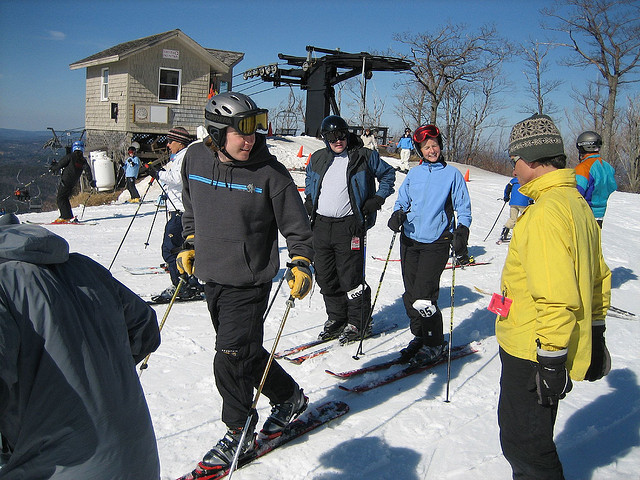

In [14]:
batch = {}
for i in dataset[sample]:
    batch[i] = torch.tensor(dataset[sample][i]).unsqueeze(0)
batch['q_word'] = ' '.join(vocab_array[batch['q'].numpy()][0])
batch['c_word'] = ' '.join(vocab_array[batch['c'].numpy()][0])
batch['target'] = dataset.answers[sample]
batch['feature'] = dataset.questions[batch['id'].item()]['img_file']
img = Image.open(os.path.join('../COCO', os.path.basename(dataset.feature_path), batch['feature'][:-3]+'jpg'))
bbox = np.load(os.path.join(dataset.feature_path, batch['feature']))['bbox']
img

## Show top-k regions related to the question

Q: what color is the jacket of the man on the
C: in a yellow and white photo of a man in a yellow ski jacket <pad>
target:
1.00 yellow

predict:  yellow


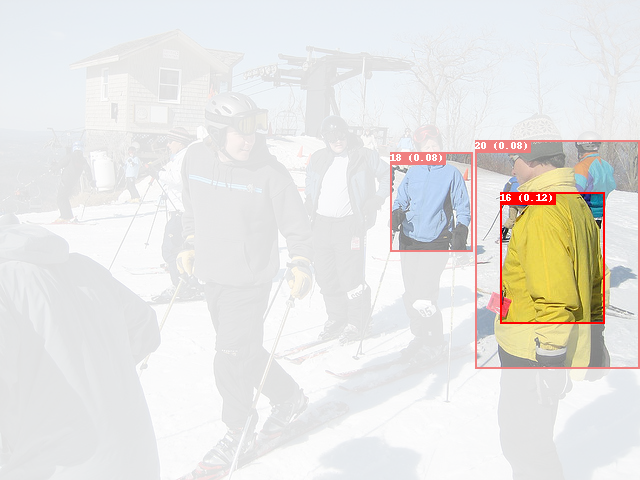

In [15]:
# Show top-k regions related to the question
att_img, regions = show_top_k_regions(model, dataset, ans_list, batch, img_path='../COCO', k=3)
att_img

In [18]:
def show_graph_att(model, batch, img_path='../COCO', feature_path='../COCO_feature_36', dataset_type='val2014', k=3, layer=-1):
    """Given a question, show the most important region and the top-k relevant regions according to the correlation scores."""
    # Get prediction and graph attentions
    model.eval()
    with torch.no_grad():
        predict, att = model.get_att(batch)
        index = att.argmax().item()
        g_att = model.encoder(batch, True)[layer].squeeze().mean(dim=1)[index,:]
        g_att[index] = 1
    
    # Prepare image and bbox
    img_file = batch['feature'][:-3] + 'jpg'
    img = Image.open(os.path.join(img_path, dataset_type, img_file))
    bbox = np.load(os.path.join(feature_path, dataset_type, batch['feature']))['bbox']
    
    # Show top-k relevant regions
    output = show_att(g_att, img, bbox, k=k+1)
    
    # Print results
    # print_result(batch, predict, ans_list)
    return output

## Show graph attention

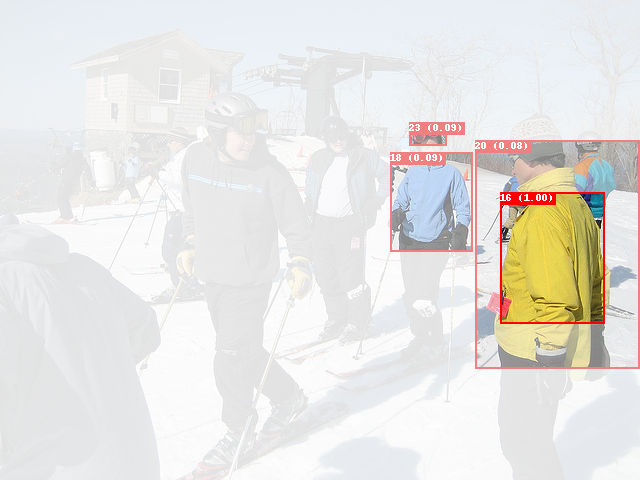

In [19]:
# Foreward
graph_att, graph_region = show_graph_att(model, batch, layer=0)
graph_att

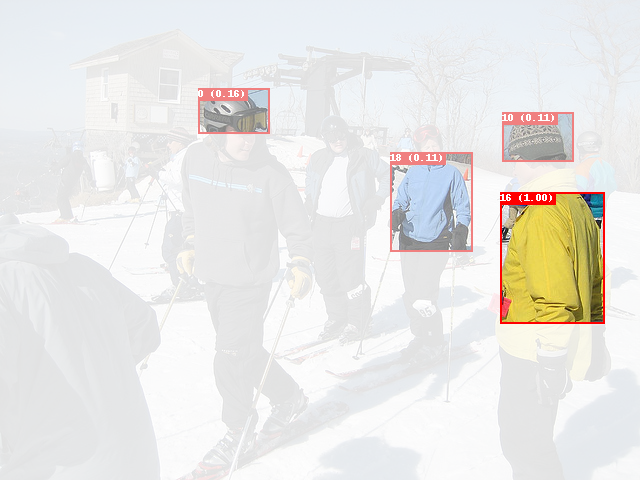

In [20]:
# Backward
graph_att, graph_region = show_graph_att(model, batch, layer=1)
graph_att

<AxesSubplot:xlabel='region no. X', ylabel='region no. Y'>

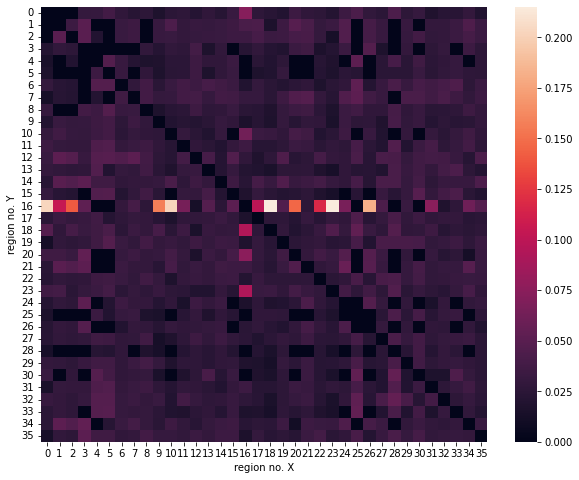

In [32]:
heat_map(model, batch)

<AxesSubplot:xlabel='region no. X', ylabel='region no. Y'>

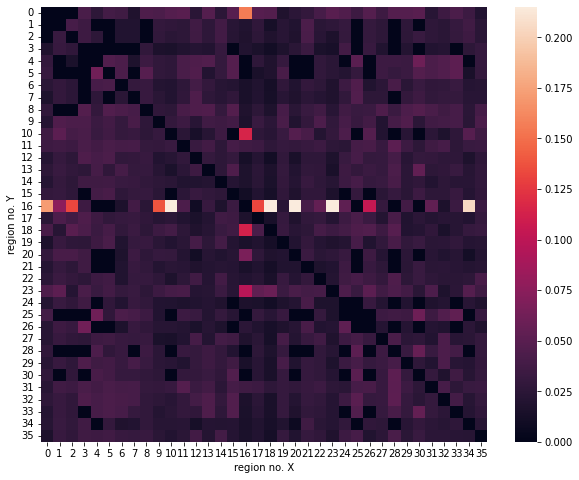

In [33]:
heat_map(model, batch, 1)

## Show caption attention in the predictor

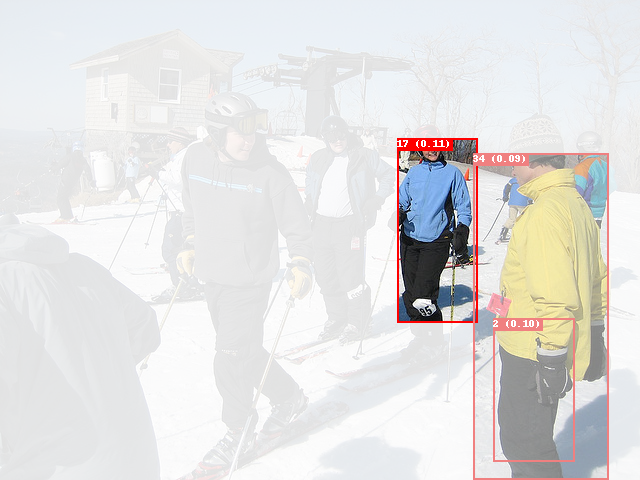

In [34]:
embed = model.encoder(batch)
att = model.predictor(embed, show_att=True)
att = att.squeeze()
cap_att, regions = show_att(att=att, img=img, bbox=bbox)
cap_att